In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten
from keras.layers import LeakyReLU,Dense,BatchNormalization,Reshape
from darknet_weight_loader import load_weights_

%matplotlib inline

Using TensorFlow backend.


In [2]:
#https://github.com/pjreddie/darknet/blob/master/cfg/yolov2-tiny-voc.cfg
anchors=np.array([[1.08,1.19],[3.42,4.41],[6.63,11.38],[9.42,5.11],[16.62,10.52]])
def yolov2_tiny_voc():
    x=Input(shape=(416,416,3))

    conv1=Conv2D(16,3,padding='same',use_bias=False)(x)
    bn1=BatchNormalization()(conv1)
    act1=LeakyReLU(alpha=0.1)(bn1)
    mp1=MaxPooling2D(pool_size=(2,2),strides=(2,2))(act1)
    
    conv2=Conv2D(32,3,padding='same',use_bias=False)(mp1)
    bn2=BatchNormalization()(conv2)
    act2=LeakyReLU(alpha=0.1)(bn2)
    mp2=MaxPooling2D(pool_size=(2,2),strides=(2,2))(act2)
    
    conv3=Conv2D(64,3,padding='same',use_bias=False)(mp2)
    bn3=BatchNormalization()(conv3)
    act3=LeakyReLU(alpha=0.1)(bn3)
    mp3=MaxPooling2D(pool_size=(2,2),strides=(2,2))(act3)
    
    conv4=Conv2D(128,3,padding='same',use_bias=False)(mp3)
    bn4=BatchNormalization()(conv4)
    act4=LeakyReLU(alpha=0.1)(bn4)
    mp4=MaxPooling2D(pool_size=(2,2),strides=(2,2))(act4)
    
    conv5=Conv2D(256,3,padding='same',use_bias=False)(mp4)
    bn5=BatchNormalization()(conv5)
    act5=LeakyReLU(alpha=0.1)(bn5)
    mp5=MaxPooling2D(pool_size=(2,2),strides=(2,2))(act5)
    
    conv6=Conv2D(512,3,padding='same',use_bias=False)(mp5)
    bn6=BatchNormalization()(conv6)
    act6=LeakyReLU(alpha=0.1)(bn6)
    mp6=MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(act6)
    
    conv7=Conv2D(1024,3,padding='same',use_bias=False)(mp6)
    bn7=BatchNormalization()(conv7)
    act7=LeakyReLU(alpha=0.1)(bn7)
    
    conv8=Conv2D(1024,3,padding='same',use_bias=False)(act7)
    bn8=BatchNormalization()(conv8)
    act8=LeakyReLU(alpha=0.1)(bn8)
    
    conv9=Conv2D(125,1,padding='same',activation='linear')(act8)
    
    y=Reshape([13,13,5,4+1+20])(conv9)
    
    model=Model(inputs=x,outputs=y)
    return model

In [3]:
model=yolov2_tiny_voc()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128       
__________

In [4]:
path_to_weights='./yolov2-tiny-voc.weights'
data=np.fromfile(path_to_weights,np.float32)
print(data.shape)

(15867889,)


In [5]:
for layer in model.layers:
    shape=[w.shape for w in layer.get_weights()]
    if shape!=[]:
        print(layer.name,shape)

conv2d_1 [(3, 3, 3, 16)]
batch_normalization_1 [(16,), (16,), (16,), (16,)]
conv2d_2 [(3, 3, 16, 32)]
batch_normalization_2 [(32,), (32,), (32,), (32,)]
conv2d_3 [(3, 3, 32, 64)]
batch_normalization_3 [(64,), (64,), (64,), (64,)]
conv2d_4 [(3, 3, 64, 128)]
batch_normalization_4 [(128,), (128,), (128,), (128,)]
conv2d_5 [(3, 3, 128, 256)]
batch_normalization_5 [(256,), (256,), (256,), (256,)]
conv2d_6 [(3, 3, 256, 512)]
batch_normalization_6 [(512,), (512,), (512,), (512,)]
conv2d_7 [(3, 3, 512, 1024)]
batch_normalization_7 [(1024,), (1024,), (1024,), (1024,)]
conv2d_8 [(3, 3, 1024, 1024)]
batch_normalization_8 [(1024,), (1024,), (1024,), (1024,)]
conv2d_9 [(1, 1, 1024, 125), (125,)]


In [6]:
load_weights_(model,path_to_weights)

Loading weights from ./yolov2-tiny-voc.weights
got 15867889 values


In [7]:
def preprocess(image):
    resized_image=cv2.resize(image,(416,416))
    normalized_image=(resized_image/255.0)
    return normalized_image

In [8]:
test_image=plt.imread('./test_images/test1.jpg')
orig_height,orig_width=test_image.shape[:2]
height_scale = orig_height / 416
width_scale = orig_width / 416
processed_image=preprocess(test_image)
batch=np.expand_dims(processed_image,axis=0)
test_out=model.predict(batch)
print(test_out.shape)

(1, 13, 13, 5, 25)


In [9]:
out=test_out[0]

In [10]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_out = np.exp(x - np.max(x, axis=-1)[..., None])
    return exp_out / np.sum(exp_out, axis=-1)[..., None]

def getBoundingBoxesFromNetOutput(clf, anchors, confidence_threshold=0.2, cell_size=32):
    pw, ph = anchors[:, 0], anchors[:, 1]
    cell_inds = np.arange(clf.shape[1])

    tx = clf[..., 0]
    ty = clf[..., 1]
    tw = clf[..., 2]
    th = clf[..., 3]
    to = clf[..., 4]

    sftmx = softmax(clf[..., 5:])
    predicted_labels = np.argmax(sftmx, axis=-1)
    class_confidences = np.max(sftmx, axis=-1)

    bx = logistic(tx) + cell_inds[None, :, None]
    by = logistic(ty) + cell_inds[:, None, None]
    bw = pw * np.exp(tw) / 2
    bh = ph * np.exp(th) / 2
    object_confidences = logistic(to)

    left = bx - bw
    right = bx + bw
    top = by - bh
    bottom = by + bh

    boxes = np.stack((
        left, top, right, bottom
    ), axis=-1) * cell_size
    
    final_confidence = class_confidences * object_confidences
    boxes = boxes[final_confidence > confidence_threshold].reshape(-1, 4).astype(np.int32)
    labels = predicted_labels[final_confidence > confidence_threshold]
    return boxes, labels

# https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression(boxes, labels, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        i = idxs[-1]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:-1]])
        yy1 = np.maximum(y1[i], y1[idxs[:-1]])
        xx2 = np.minimum(x2[i], x2[idxs[:-1]])
        yy2 = np.minimum(y2[i], y2[idxs[:-1]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:-1]]
 
        # delete all indexes from the index list that have
        idxs = (idxs[:-1])[overlap < overlapThresh]
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick], labels[pick]

In [11]:
boxes,labels=getBoundingBoxesFromNetOutput(out,anchors)
boxes,labels=non_max_suppression(boxes,labels,0.4)
print(boxes)
print(labels)

[[340 230 416 293]
 [263 233 304 284]]
[6 6]


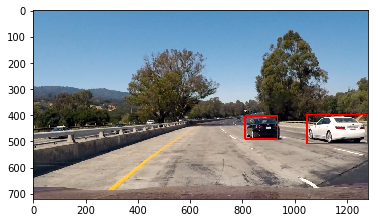

In [12]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

img=test_image.copy()
if len(boxes) > 0:
    for (left, top, right, bottom), label in zip(boxes, labels):

        left = int(left * width_scale)
        top = int(top * height_scale)
        right = int(right * width_scale)
        bottom = int(bottom * height_scale)

        cv2.rectangle(img, (left, top), (right, bottom), color=(255, 0, 0), thickness=3)
        cv2.putText(
            img, voc_classes[label], (left, top-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0)
        )

plt.imshow(img)